In [411]:
!pip install benchmarl vmas

In [99]:
import torch
import numpy as np
from vmas import make_env
from vmas.simulator.core import Agent, World, Landmark
from vmas.simulator.scenario import BaseScenario
from vmas.simulator.utils import Color
import random
import gym
import torch
from benchmarl.algorithms import MappoConfig
from benchmarl.environments import Task
from benchmarl.experiment import Experiment, ExperimentConfig
from benchmarl.models.common import SequenceModelConfig
import matplotlib.pyplot as plt

In [100]:
action_mask = torch.tensor([
            [-1, 0],  # Left
            [1, 0],   # Right
            [0, 1],   # Up
            [0, -1],  # Down
        ])

In [101]:
action_mask[0] + action_mask[2]

tensor([-1,  1])

In [383]:
class DiscreteGridTrafficScenario(BaseScenario):
    def make_world(self, batch_dim: int, device: torch.device, **kwargs):
        # Environment parameters from the paper
        self.grid_size = kwargs.get("grid_size", 10)  # N_x^1 = N_x^2 = grid_size
        self.num_agents = kwargs.get("num_agents", 20)
        self.max_steps = kwargs.get("max_steps", 100)
        self.congestion_weight = kwargs.get("congestion_weight", 1)  # λ parameter
        self.time_penalty = kwargs.get("time_penalty", 0.5)  # Constant time penalty per step

        # Create world
        world = World(batch_dim, device, dt=1.0, substeps=1)  # Discrete time steps

        self.action_mask = torch.tensor([
            [-1, 0],  # Left
            [1, 0],   # Right
            [0, 1],   # Up
            [0, -1],  # Down
        ])


        # Add agents (vehicles/followers)
        self.agents = []
        for i in range(self.num_agents):
            agent = Agent(
                name=f"vehicle_{i}",
                collide=False,  # Collisions handled in grid logic
                u_range=1.0,
                max_speed=1.0,
                color=Color.BLUE,
                discrete_action_nvec=[4],
                action_size=1

            )
            world.add_agent(agent)
            self.agents.append(agent)

        # Add target location (0,0) as landmark
        self.target = Landmark(
            name="target",
            collide=False,
            shape=None,
            color=Color.GREEN,
        )
        world.add_landmark(self.target)
        self.target.set_pos(torch.tensor([0, 0]), batch_index=None)

        # Create grid obstacles (from paper)
        self.obstacles = []
        self.obstacle_map = torch.zeros((self.grid_size, self.grid_size), device=device, dtype=torch.bool)

        # Initialize population distribution tracking
        self.mean_field_distribution = torch.zeros((self.grid_size, self.grid_size), device=device)
        self.step_count = 0

        return world

    def reset_world_at(self, env_index: int = None):
        # Initialize agents at random positions (except target and obstacles)
        random.seed(42)
        torch.manual_seed(42)
        for agent in self.agents:
            while True:
                # Random grid position
                pos = torch.tensor([
                    torch.randint(self.grid_size - 2, self.grid_size, (1,)).item(),
                    torch.randint(self.grid_size - 2, self.grid_size, (1,)).item()
                ], device=agent.device, dtype=torch.int32)
                # Check if position is valid (not obstacle and not target)
                cell_x, cell_y = int(pos[0].item()), int(pos[1].item())
                if (cell_x, cell_y) != (0, 0) and not self.obstacle_map[cell_x, cell_y]:
                    break

            agent.set_pos(pos, batch_index=env_index)
            agent.set_vel(torch.zeros(2, device=agent.device), batch_index=env_index)

        # Reset population distribution
        self.update_mean_field_distribution()
        self.step_count = 0

    def update_mean_field_distribution(self):
        """Update the population distribution μ_t across the grid"""
        # Reset distribution
        self.mean_field_distribution = torch.zeros((self.grid_size, self.grid_size),
                                                 device=self.world.device)

        # Count agents in each cell
        for agent in self.agents:
            pos = agent.state.pos
            cell_x = min(self.grid_size-1, max(0, pos[0,0].item()))
            cell_y = min(self.grid_size-1, max(0, pos[0,1].item()))
            self.mean_field_distribution[cell_x, cell_y] += 1

        # Normalize to get distribution (probability mass function)
        if self.num_agents > 0:
            self.mean_field_distribution /= self.num_agents

    def get_cell_population(self, position):
        """Get population density at a given grid position"""
        cell_x = min(self.grid_size-1, max(0, position[0,0].item()))
        cell_y = min(self.grid_size-1, max(0, position[0,1].item()))
        return self.mean_field_distribution[cell_x, cell_y]

    def is_valid_move(self, current_pos, move):
        """Check if a move is valid (within grid and not blocked)"""
        new_pos = current_pos + move

        # This is the consistent, safe method.
        cell_x = min(self.grid_size-1, max(0, new_pos[0,0].item()))
        cell_y = min(self.grid_size-1, max(0, new_pos[0,1].item()))

        intended_cell_x = new_pos[0,0].item()
        intended_cell_y = new_pos[0,1].item()

        # Check if the intended cell is different from the clamped cell.
        if intended_cell_x != cell_x or intended_cell_y != cell_y:
            return False

        # Now check obstacles on the valid cell.
        if self.obstacle_map[cell_x, cell_y]:
            return False

        if intended_cell_x > 9 or intended_cell_y > 9 or intended_cell_x < 0 or intended_cell_y < 0:
            return False

        return True

    def discrete_transition(self, agent: Agent, action_idx: int):
        """Apply discrete transition dynamics based on paper"""
        move = self.action_mask[action_idx]

        # Check if move is valid
        if self.is_valid_move(agent.state.pos, move):
            new_pos = agent.state.pos + move
            agent.set_pos(new_pos, batch_index=None)
        # If invalid, agent stays in place (as per paper's dynamics)

        return agent.state.pos

    def reward(self, agent: Agent):
        # Negative cost as reward (to be maximized)
        time_penalty = self.time_penalty
        pos = torch.round(agent.state.pos)

        # This is the consistent, safe method.
        cell_x = min(self.grid_size-1, max(0, pos[0,0].item()))
        cell_y = min(self.grid_size-1, max(0, pos[0,1].item()))

        # Congestion penalty (λ * μ(x))
        congestion = self.mean_field_distribution[cell_x, cell_y]
        congestion_penalty = self.congestion_weight * torch.tensor(congestion, device=agent.device)

        # Check if at target
        at_target = torch.all(torch.eq(agent.state.pos, torch.tensor([0, 0], device=agent.device)))
        if at_target:
            # No further cost if at target
            return torch.tensor(0.0, device=agent.device)

        # Total cost as described in the paper
        total_cost = time_penalty + congestion_penalty

        return total_cost

    def observation(self, agent: Agent):
        # Convert continuous position to discrete grid cell
        discrete_pos = agent.state.pos
        discrete_pos = discrete_pos.reshape(-1)
        cell_x = int(discrete_pos[0].item())
        cell_y = int(discrete_pos[1].item())

        # 1. Agent's discrete position (normalized)
        pos = discrete_pos / self.grid_size

        # 2. Target relative position (normalized)
        target_rel = self.target.state.pos - discrete_pos
        target_rel = target_rel / self.grid_size
        target_rel = target_rel.reshape(-1)

        # 3. ENTIRE GRID population distribution (mean field)
        # Flatten the grid distribution and add to observation
        grid_distribution_flat = self.mean_field_distribution.flatten()

        obs = torch.cat((grid_distribution_flat, target_rel, pos), dim=0)

        return obs

    def done(self):
        # Check if all agents reached the target
        all_at_target = True
        for agent in self.agents:
            if not torch.all(torch.eq(agent.state.pos, torch.tensor([0, 0], device=agent.device))):
                all_at_target = False
                break

        # Or if max steps reached
        max_steps_reached = self.step_count >= self.max_steps

        # Return as a tensor, not a bool!
        done = all_at_target or max_steps_reached

        done_tensor = torch.tensor(done, device=self.world.device, dtype=torch.bool)

        return done_tensor

    def extra_step(self):
        # Update population distribution
        self.update_mean_field_distribution()
        self.step_count += 1


# Wrapper to handle discrete actions
class DiscreteActionWrapper:
    def __init__(self, env):
        self.env = env
        self.scenario = env.scenario
        self.fig, self.ax = None, None  # for reuse

    def step(self, actions):
        #Handle discrete actions and apply discrete transitions
        # Apply discrete transitions to all agents
        for i, action_idx in enumerate(actions):
            # Apply the discrete grid transition
            agent = self.env.agents[i]
            self.scenario.discrete_transition(agent, action_idx.item())

        # Update scenario-specific state (population distribution, step count)
        self.scenario.extra_step()

        # Get observations, rewards, and done status
        observations = [self.scenario.observation(agent) for agent in self.scenario.agents]
        rewards = [self.scenario.reward(agent) for agent in self.scenario.agents]
        done = self.scenario.done()

        return observations, rewards, done, {}

    def render(self, mode="human"):
        grid_size = self.scenario.grid_size

        # Convert mean-field distribution (agent density) to numpy
        density = self.scenario.mean_field_distribution.detach().cpu().numpy()

        # Start figure if first time
        if self.fig is None:
            self.fig, self.ax = plt.subplots()

        self.ax.clear()

        # Plot heatmap (reds = high density, white = low density)
        cmap = plt.cm.Reds
        cmap.set_bad(color="black")  # obstacles → black

        # Use extent to properly align the grid
        im = self.ax.imshow(
            density,  # No need to flipud anymore
            origin='upper',  # Set origin to upper to match grid coordinates
            cmap=cmap,
            interpolation="nearest",
        )

        # Mark target (0,0) as green square - now at top-left
        self.ax.scatter(0, 0, marker="s", c="lime", edgecolor="black", s=200, label="Target")

        # Add gridlines at integer positions
        self.ax.set_xticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_yticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True, which="both", color="black", linewidth=0.5)

        # Set limits to ensure proper alignment
        self.ax.set_xlim(-0.5, grid_size-0.5)
        self.ax.set_ylim(-0.5, grid_size-0.5)

        # Add colorbar (density scale)
        self.fig.colorbar(im, ax=self.ax, fraction=0.046, pad=0.04, label="Agent density")

        plt.pause(0.01)  # non-blocking update
        if mode == "human":
            plt.show(block=False)


    def __getattr__(self, name):
        #Delegate all other methods to the wrapped environment
        return getattr(self.env, name)

    def close(self):
      if self.fig is not None:
          plt.close(self.fig)
          self.fig, self.ax = None, None



In [384]:
from vmas import make_env
env = make_env(
    scenario = DiscreteGridTrafficScenario(),
    continuous_actions=False,
    num_envs = 1,
)

In [385]:
env = DiscreteActionWrapper(env)

In [386]:
actions = env.get_random_actions()
actions

[tensor([2]),
 tensor([2]),
 tensor([1]),
 tensor([3]),
 tensor([3]),
 tensor([3]),
 tensor([3]),
 tensor([2]),
 tensor([1]),
 tensor([1]),
 tensor([2]),
 tensor([1]),
 tensor([2]),
 tensor([3]),
 tensor([2]),
 tensor([3]),
 tensor([3]),
 tensor([0]),
 tensor([2]),
 tensor([0])]

In [387]:
for agent in env.agents:
    print(agent.state.pos)

tensor([[8, 9]], dtype=torch.int32)
tensor([[8, 8]], dtype=torch.int32)
tensor([[8, 9]], dtype=torch.int32)
tensor([[8, 8]], dtype=torch.int32)
tensor([[8, 9]], dtype=torch.int32)
tensor([[8, 8]], dtype=torch.int32)
tensor([[8, 8]], dtype=torch.int32)
tensor([[9, 8]], dtype=torch.int32)
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 8]], dtype=torch.int32)
tensor([[9, 8]], dtype=torch.int32)
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 9]], dtype=torch.int32)
tensor([[8, 8]], dtype=torch.int32)
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 8]], dtype=torch.int32)
tensor([[9, 8]], dtype=torch.int32)
tensor([[8, 8]], dtype=torch.int32)


In [401]:
obs, rews, dones, info = env.step(actions)

/tmp/ipython-input-773504104.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  congestion_penalty = self.congestion_weight * torch.tensor(congestion, device=agent.device)


In [402]:
print(f"Obs length: {len(obs)}, observation of agent 0:\n{obs[0]}")

Obs length: 20, observation of agent 0:
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0500,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0500,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.2000,  0.0500,  0.0000,  0.0000,  0.0000,
         0.0000,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1000,  0.0000,


In [403]:
for agent in env.agents:
    print(agent.state.pos)

tensor([[8, 9]], dtype=torch.int32)
tensor([[8, 9]])
tensor([[9, 9]])
tensor([[8, 3]])
tensor([[8, 4]])
tensor([[8, 3]])
tensor([[8, 3]])
tensor([[9, 9]])
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 8]], dtype=torch.int32)
tensor([[9, 9]])
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 9]], dtype=torch.int32)
tensor([[9, 4]])
tensor([[9, 9]], dtype=torch.int32)
tensor([[8, 3]])
tensor([[9, 4]])
tensor([[4, 8]])
tensor([[9, 9]])
tensor([[3, 8]])


In [404]:
print(f"Rewards length: {len(rews)}, reward of agent 0:\n{rews[19]}")

Rewards length: 20, reward of agent 0:
0.550000011920929


In [405]:
print(dones)

tensor(False)


In [406]:
env.scenario.mean_field_distribution[7,8]

tensor(0.)

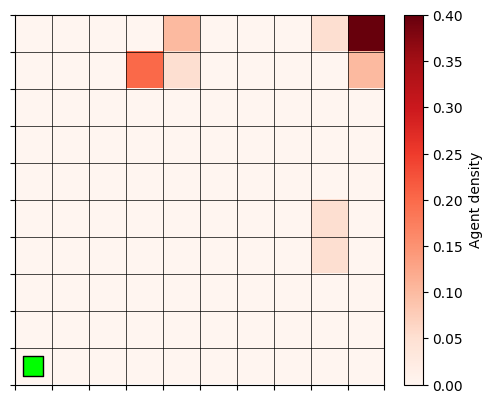

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [409]:
env.render()

In [408]:
env.close()

In [412]:
# @title Install GNN dependencies
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.6 MB/s eta 0:00:00
